In [1]:
import pertpy as pt

[rank: 0] Global seed set to 0


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
import pickle
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from distance_result import DistanceResult
from utils import annotate, scanpy_setup, ctrl_categories_setup
from utils import sample_and_merge_control_random, remove_groups, subsample, generate
from utils import get_pwdf_per_condition, get_melted_df_per_perturbation
from utils import get_flat_df, normalize_per_metric, get_distance_per_perturbation, add_rank_col
from utils import plt_legend, inplace_check

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

Load in the main simulation dataset. This contains a large variety of conditions generated with different degrees of perturbation and foldchanges, and some variation in control.

In [6]:
adata = ad.AnnData(pd.read_csv('../splatter_sim.csv').T, obs=pd.read_csv('../splatter_sim_obs.csv'))

Map simulation parameters to groups, and set the `perturbation` label column.

In [7]:
params = pd.read_csv('../splatter_sim_params.csv')
annotate(adata, params)

Standard scanpy functions needed for calculating distances.

In [8]:
scanpy_setup(adata)

In summary, our adata now looks like this.

In [9]:
adata

AnnData object with n_obs × n_vars = 40000 × 10000
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'Step', 'group', 'Prob', 'DEProb', 'DownProb', 'FacLoc', 'FacScale', 'Steps', 'Skew', 'log(DEProb)', 'perturbation'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

Set the metrics we'll be evaluating.

In [10]:
controls = ['control0', 'control1', 'control2', 'control3', 'control4']
# metrics = ['euclidean', 'pearson_distance', 'mean_absolute_error', 'r2_distance', 'spearman_distance']  # fast
# metrics = ['mmd', 'wasserstein', 'kl_divergence', 't_test', 'nb_ll', 'mean_absolute_error', 'euclidean', 'pearson_distance', 'spearman_distance', 'cosine_distance', 'r2_distance', 'edistance', 'mean_pairwise']
# metrics = ['wasserstein', 'mmd', 'kl_divergence', 't_test']  # the experimental ones

# working metrics
metrics = ['euclidean', 'pearson_distance', 'mean_absolute_error', 'r2_distance', 'spearman_distance',\
           'mmd', 'kl_divergence', 't_test', 'wasserstein',\
           'edistance', 'mse', 'cosine_distance']

In [11]:
results = {}

In [ ]:
%%time
with open('metric_runs_simulated.pkl', 'rb') as file:
    results = pickle.load(file)
print(results.keys())

### sanity checks

Plot what these simulated perturbations look like.

Check that the mean-variance relationship we'd expect is preserved.

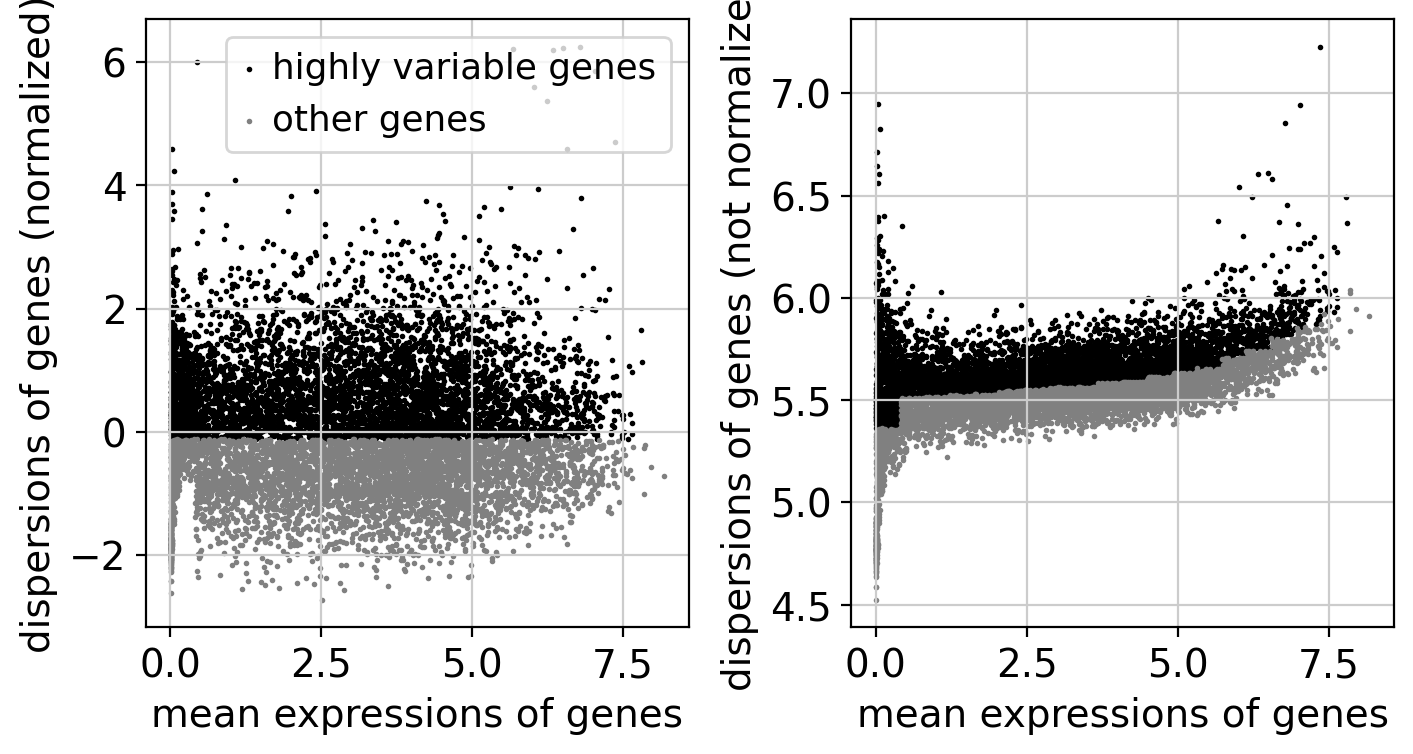

In [15]:
sc.pl.highly_variable_genes(adata)

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

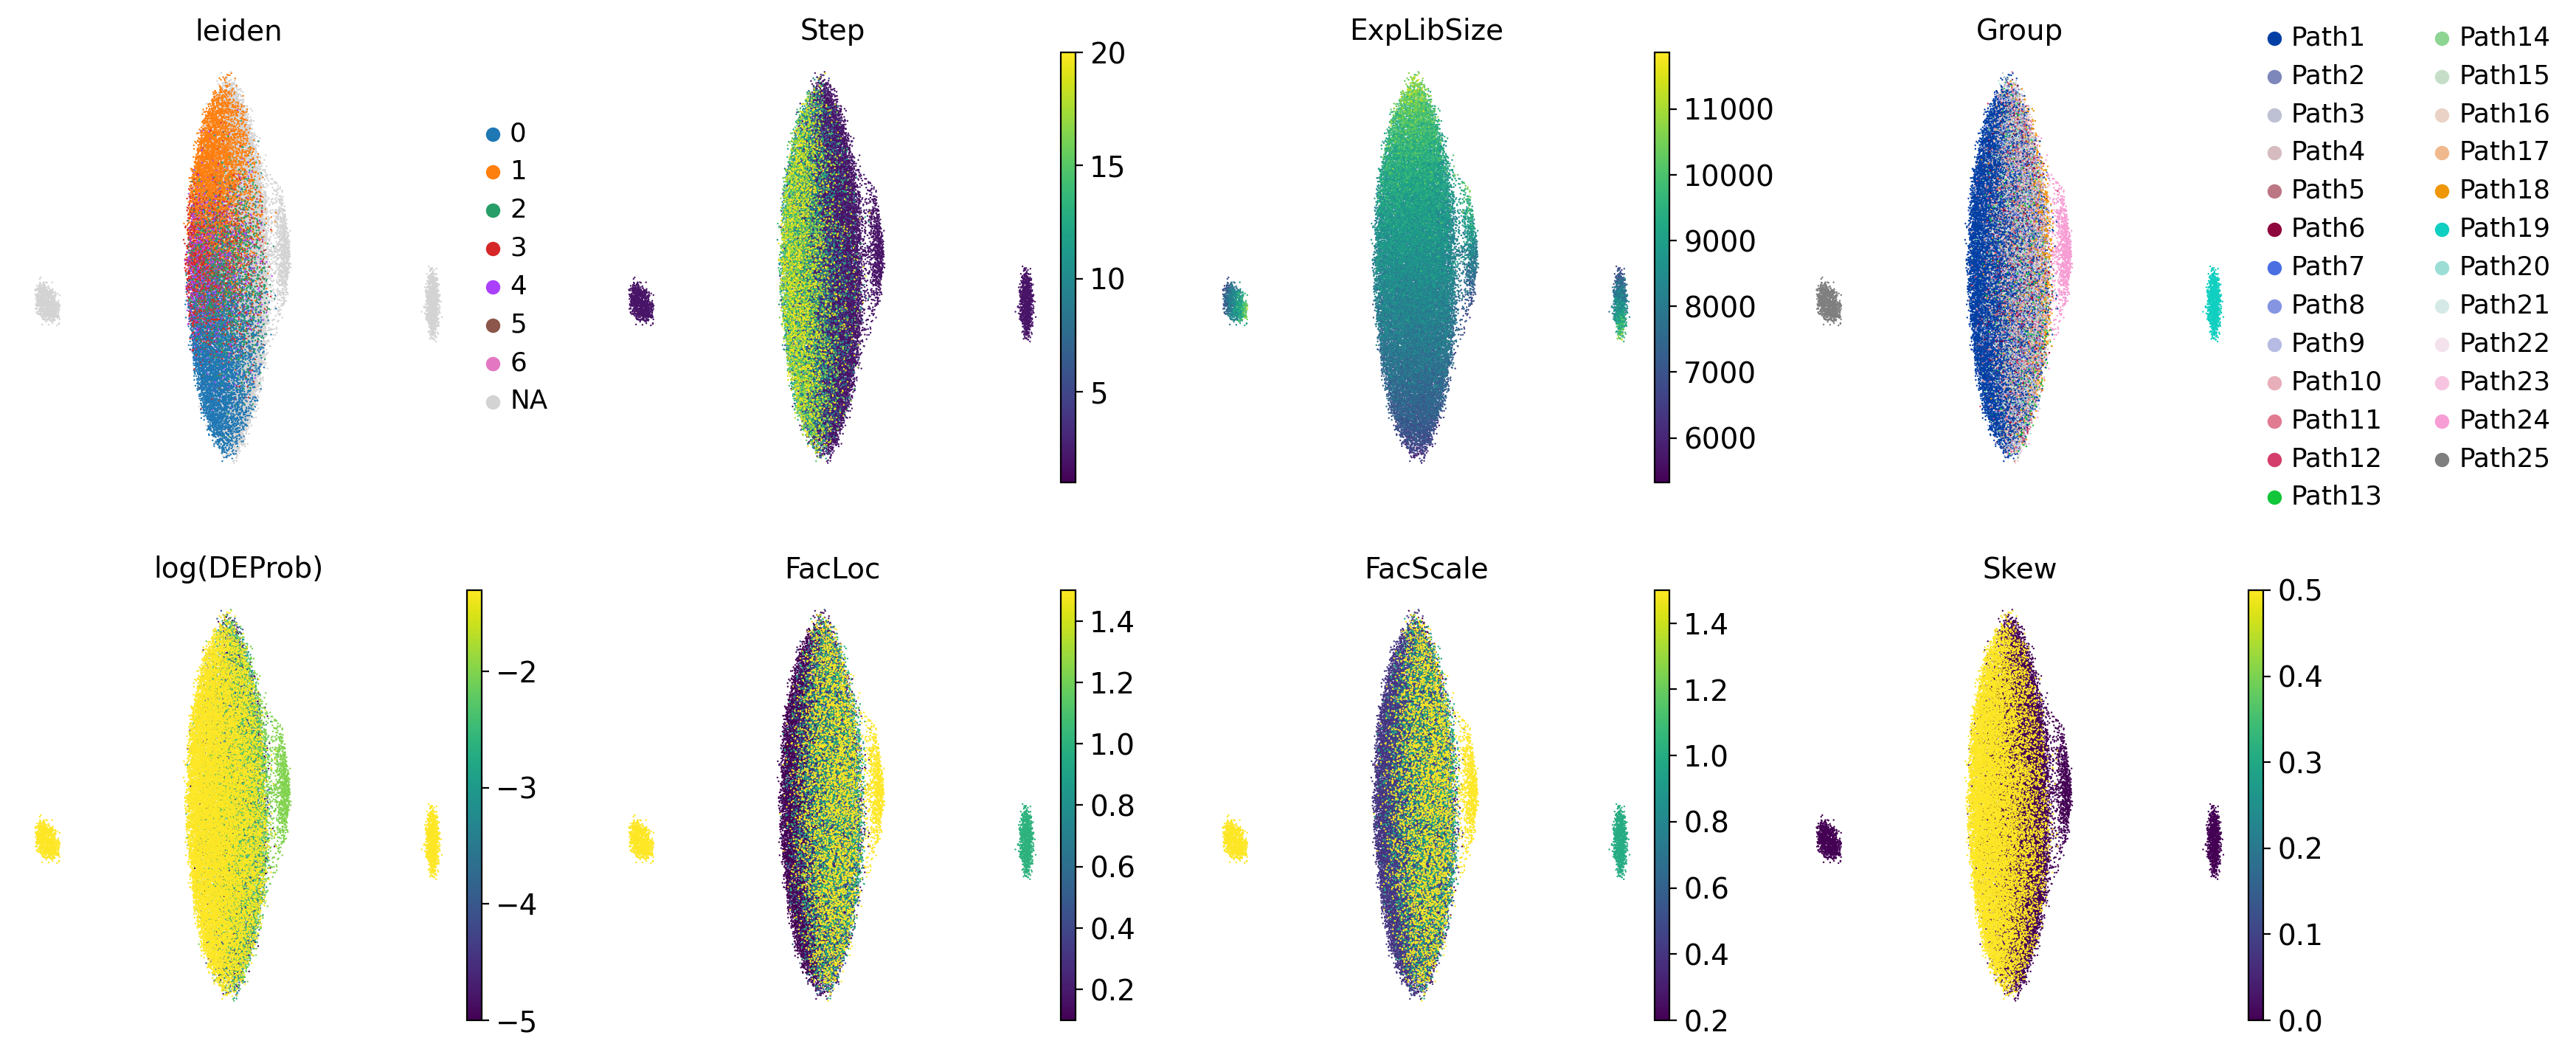

In [14]:
sc.pl.umap(adata, color=['leiden', 'Step', 'ExpLibSize', 'Group', 'log(DEProb)', 'FacLoc', 'FacScale', 'Skew'], ncols=4)

Double check that the number of differentially expressed genes increases. Note that we don't expect differential testing to be sensitive enough for the first few conditions set to be subtle perturbations.

In [16]:
sc.tl.rank_genes_groups(adata, groupby='Group', reference='Path1')

In [17]:
results = []

for group in adata.obs.Group.cat.categories:
    if group == 'Path1':
        continue
    df = sc.get.rank_genes_groups_df(adata, group=group)
    fc_count = df[np.abs(df.logfoldchanges) > 1].shape[0]
    pos_fc_count = df[df.logfoldchanges > 0].shape[0]
    results.append({'Group': group, 'fc_count': fc_count, 'pos_fc_count': pos_fc_count})

# Create a DataFrame from the results list
result_df = pd.DataFrame(results)

result_df

,Group,fc_count,pos_fc_count
0,Path2,1067,4718
1,Path3,1066,4771
2,Path4,1116,4751
3,Path5,1083,4649
4,Path6,1091,4618
5,Path7,1210,4245
6,Path8,1061,4533
7,Path9,1112,4670
8,Path10,1085,4486
9,Path11,1101,4393


Dunno why the number of positive changes goes down, but okay.

## run metrics for different numbers of cells

Let's set up the adata a little:

1. Sample disjoint control cells from the control population (`sample_and_merge_control_random`)
2. Subsample to the same number of cells in each condition, include controls (`subsample`).
3. Generate a different dataset per experiment scenario (`generate`)

Get pairwise distances dataframes for each metric and experimental condition.

In [12]:
n = 600
merged = sample_and_merge_control_random(adata, 'control', n=5)
filtered = subsample(merged, n)

In [13]:
experiment_condi = list(range(100, n+10, 100))

for ncell in experiment_condi:
    print(ncell)
    subset = generate(ncell, filtered, min_cells=n)[:, adata.var['highly_variable']]
    
    for rep in ['pca', 'lognorm', 'counts']:
        inplace_check(metrics, results, DistanceResult(subset, str(ncell), rep, 'n_cells'))

100


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


200
300
400
500
600


### Distance as a factor of number of DEGs (only available for simulated data)

Use these runs to also visualize increase in distances due to number of DEGs.

First, we'll take the distance of each perturbation from control, averaged across the 5 control populations. We'll also take the average distance of a control population from each other.

In [41]:
dfs, ctrls = get_distance_per_perturbation(pwdfs, 800, metrics, controls)

control: 1.6250221252441406
control: 6.647304534912109
control: 49.400797271728514


Concatenate the individual metric dataframes and label with the parameters used to generate each simulated perturbation.

In [42]:
df = pd.concat(dfs).reset_index()
df.columns = ['perturbation', 'distance', 'metric']
for col in params.columns:
    df[col] = df['perturbation'].map(dict(zip(adata.obs.perturbation, adata.obs[col])))

Plot how the distances vary with number of differentially expressed genes (`DEProb`) and degree of differential expression (`FacLoc`).

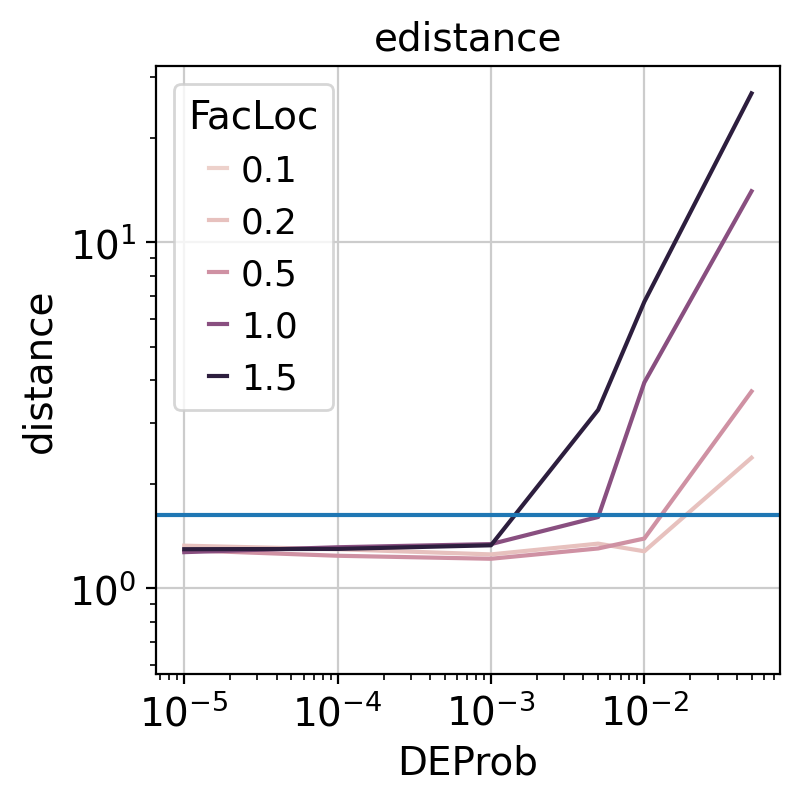

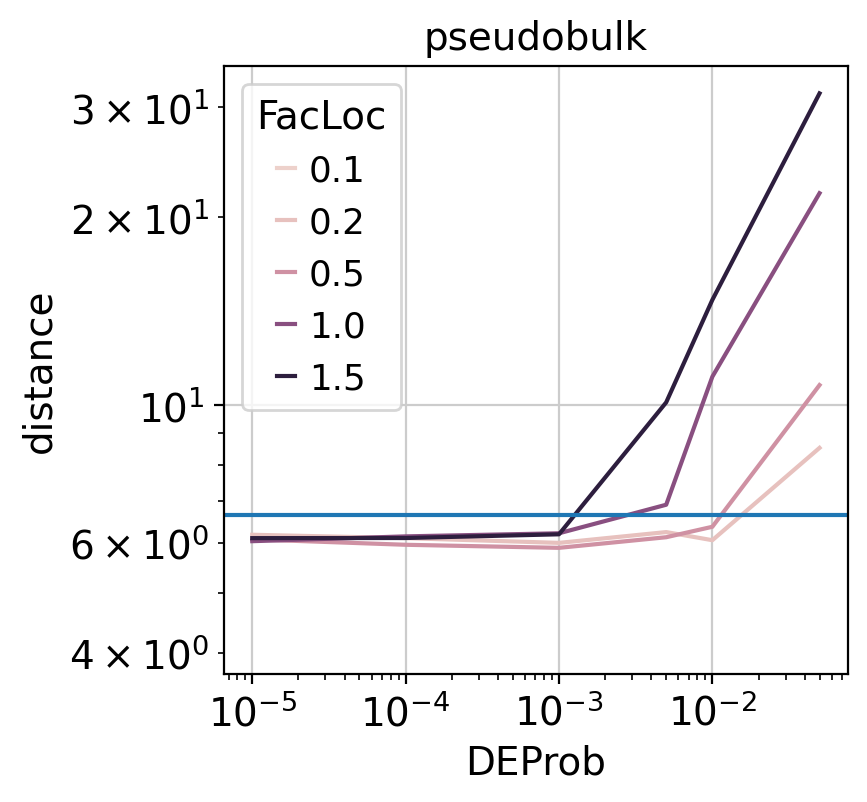

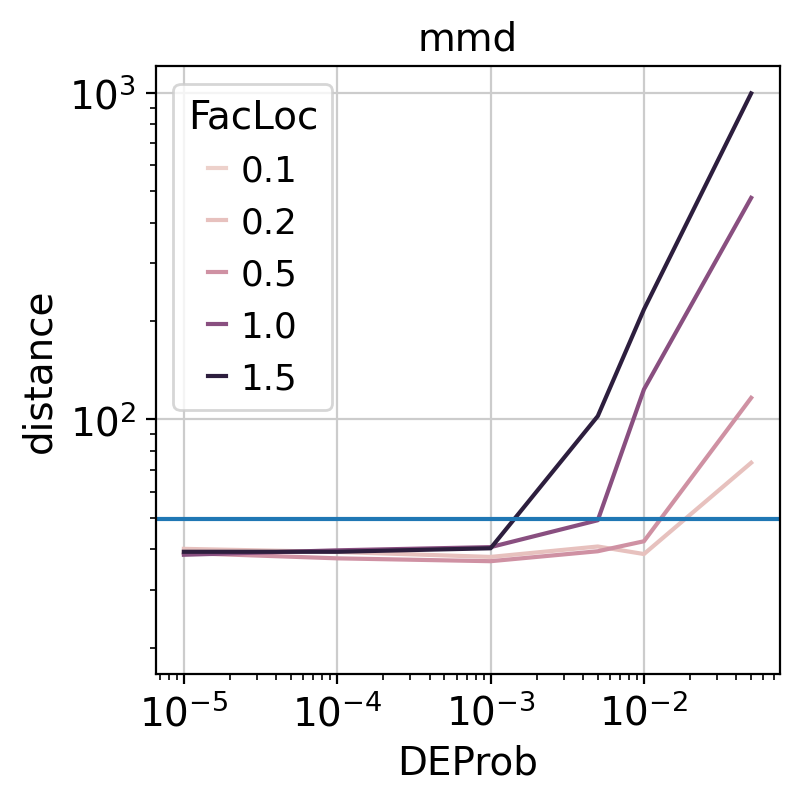

In [43]:
for metric in metrics:    
    sns.lineplot(data = df[df.metric == metric], x='DEProb', y='distance', hue='FacLoc')
    plt.axhline(ctrls[metric])

    plt.xscale('log')
    plt.yscale('log')
    plt.title(metric)
    plt.show()

Something's going wrong here... the lines should not all have the same behavior.

Finally and most importantly, the relative differences of perturbations with each other changes as `DEProb` and `FacLoc` change, and this relative difference is (should be) different per metric.

In [44]:
add_rank_col(df, dfs[0])

In [45]:
df['log(DEProb)'] = np.log(df['DEProb'])

TODO: why are the Deprobs here different?? I set them to be all the same

Text(0, 0.5, 'scaled distance')

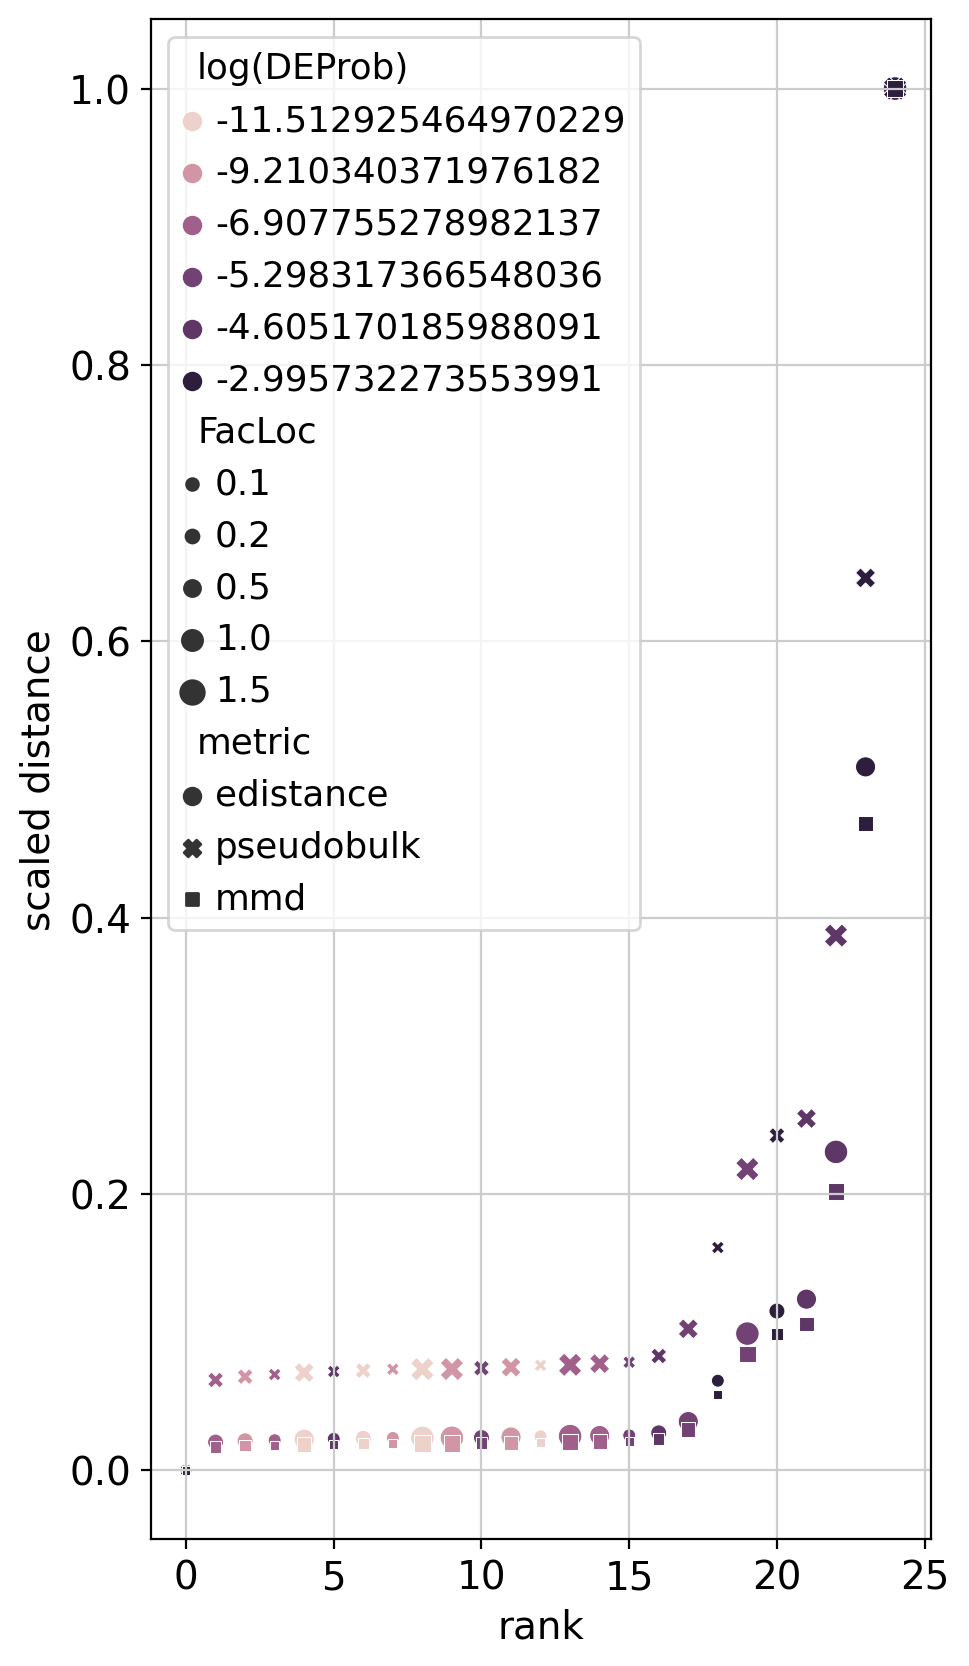

In [46]:
normed_df = normalize_per_metric(df, label='distance')

plt.figure(figsize=(5, 10))
sns.scatterplot(data=normed_df, x='rank', y='distance', style='metric', hue='log(DEProb)', size='FacLoc')
# for i, row in normed_df[normed_df.perturbation == 'control'].iterrows():
#     plt.axhline(row['distance'], label=row['metric'])
plt.ylabel('scaled distance')

## run metrics for different numbers of HVGs

How does the number of HVGs selected impact these metrics? We'll also look at whether the different flavors of HVG selection offered by `scanpy` matter here.

We'll select the HVGs from the original 10k, while including all conditions, including those that might not have enough cells.

In [14]:
experiment_condi = [10, 50, 100, 500, 1000, 2000, 5000]  # number of HVGs

feature_subsets = {}
for n in experiment_condi:
    sc.pp.highly_variable_genes(adata, n_top_genes=n, flavor='seurat')
    feature_subsets[n] = list(adata.var_names[adata.var['highly_variable']])
    
# reset highly_variable genes for the remaining experiments
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

We'll still produce 5 control conditions to average over so that we get a distribution of metric values. Filter for conditions with a minimum of 250 cells, which we see from the above plot has a reasonable amount of variance in the metric. 

In [15]:
merged = sample_and_merge_control_random(adata, 'control')
filtered = subsample(merged, 300)

Calculate metrics for each perturbation.

In [16]:
for n, features in feature_subsets.items():
    print(n)
    subset = filtered[:, features]
    
    for rep in ['lognorm', 'counts', 'pca']:
        inplace_check(metrics, results, DistanceResult(subset, str(n), rep, 'n_genes'))

10
50
100
500
1000
2000
5000


#### Sensitivity:

In [268]:
from utils import get_melted_df_per_perturbation

In [269]:
df, ctrls = get_melted_df_per_perturbation(filtered, pwdfs, metrics, controls, 'n_genes', reference='spearman_distance-50')
for col in params.columns:
    df[col] = df['perturbation'].map(dict(zip(adata.obs.perturbation, adata.obs[col])))

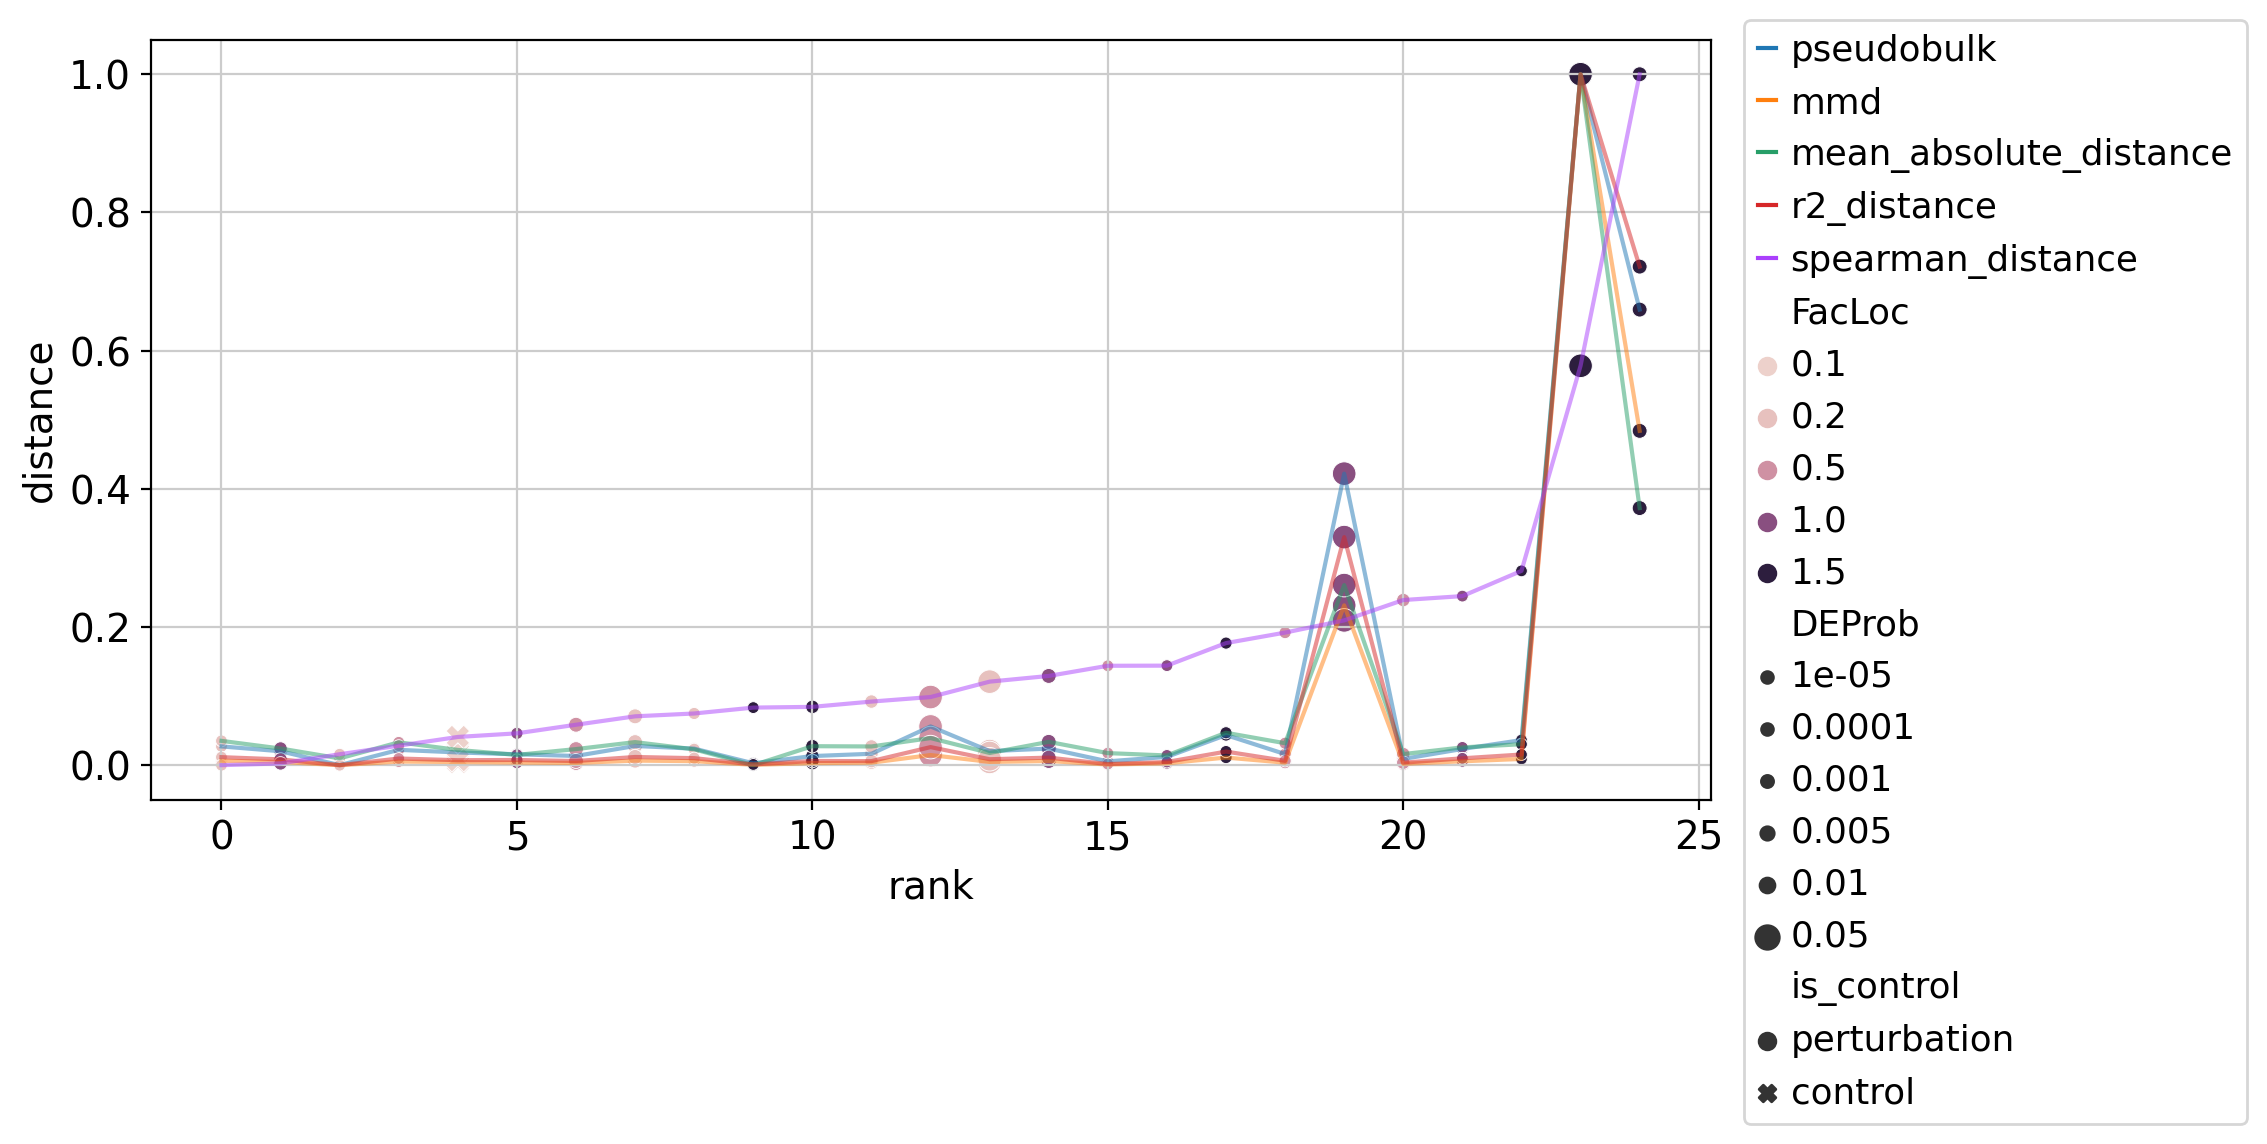

In [270]:
normed_df = normalize_per_metric(df[df.n_genes == '50'], label='distance')
plt.figure(figsize=(10, 5))
sns.lineplot(data=normed_df, x='rank', y='distance', hue='metric', alpha=.5)
sns.scatterplot(data=normed_df, x='rank', y='distance', hue='FacLoc', style='is_control', size='DEProb')
plt.legend(bbox_to_anchor=(1.01, 1.05))

Spearman is the most well-behaved on simulated data.

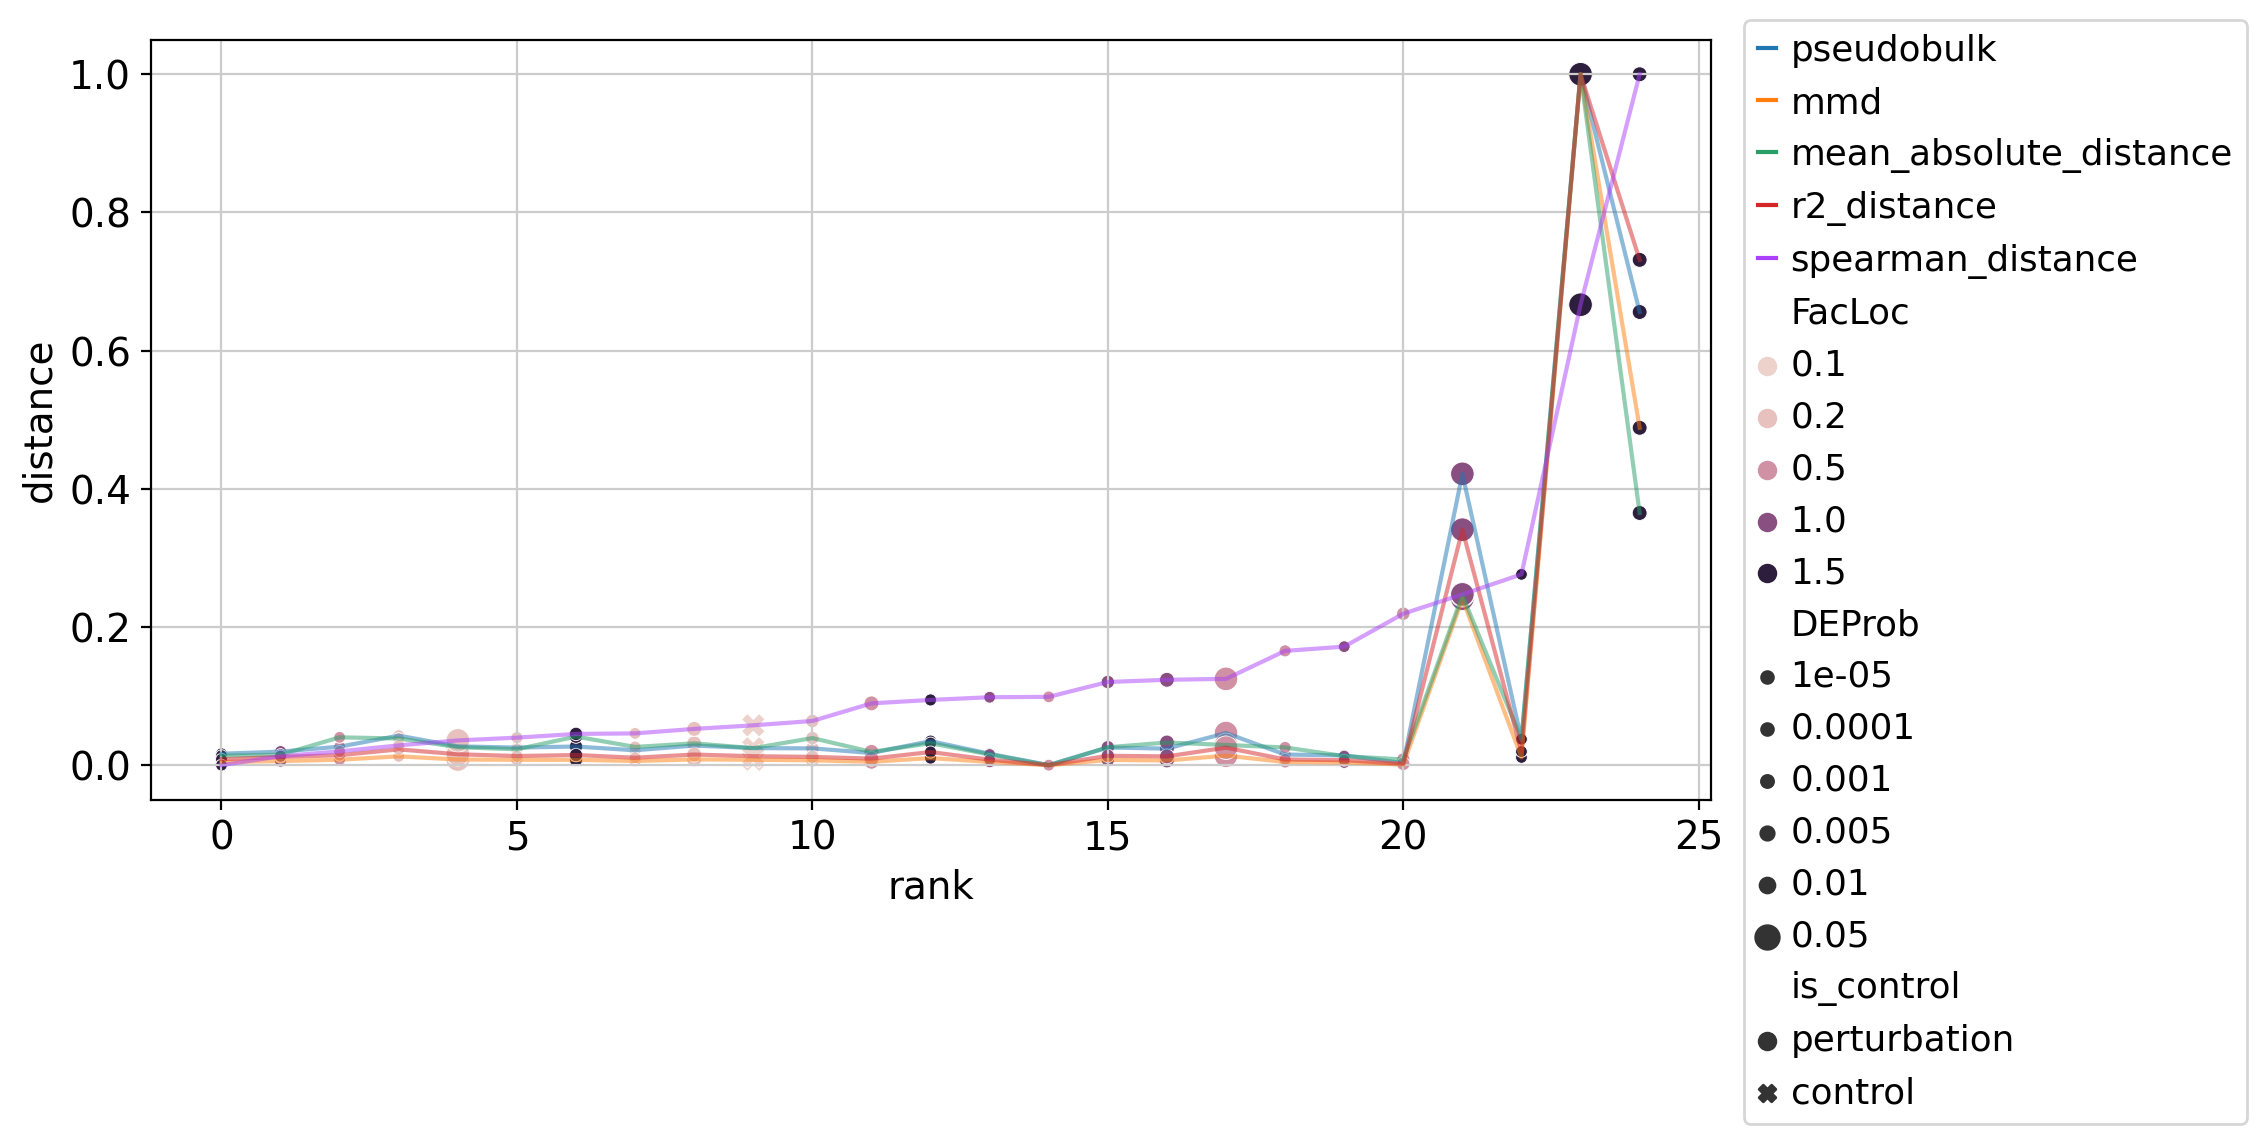

In [149]:
normed_df = normalize_per_metric(df[df.n_genes == '50'], label='distance')
plt.figure(figsize=(10, 5))
sns.lineplot(data=normed_df, x='rank', y='distance', hue='metric', alpha=.5)
sns.scatterplot(data=normed_df, x='rank', y='distance', hue='FacLoc', style='is_control', size='DEProb')
plt.legend(bbox_to_anchor=(1.01, 1.05))

## run metrics for different numbers of DEGs

How does the number of DEGs selected impact these metrics? Note that we're only using scanpy's `rank_genes_groups` here.

We'll still produce 5 control conditions to average over so that we get a distribution of metric values. Filter for conditions with a minimum of 300 cells, which we see from the above plot has a reasonable amount of variance in the metric. 

In [ ]:
merged = sample_and_merge_control_random(adata, 'control')
filtered = subsample(merged, 300)  # TODO debatable, this is to match sciplex

We'll calculate differentially expressed genes per condition, and then take a variable number from the top using `generate_DEG_adatas`.

In [ ]:
included_perturbations = [x for x in filtered.obs.perturbation.unique() if 'control' not in x] # set groups to save runtime
sc.tl.rank_genes_groups(
    adata,
    groupby='perturbation',
    groups=included_perturbations,
    reference='control',
    rankby_abs=True
)

Calculate metrics for each perturbation.

In [ ]:
experiment_condi = [10, 50, 100, 150, 200]

for n in experiment_condi:
    print(n)
    subset = generate_DEG_adatas(adata, filtered, included_perturbations, n)
    
    inplace_check(metrics, results, DistanceResult(subset, str(n), 'lognorm', 'n_DEGs'))

In [40]:
distance = pt.tools.Distance(metric='euclidean', layer_key='lognorm')
target_adata = filtered
# calc_DEG_pwdf(target_adata, distance)

In [41]:
def calc_DEG_pwdf(target_adata, distance):
    controls = ['control0', 'control1', 'control2', 'control3', 'control4']

    sub_pwdfs = []
    for p in included_perturbations:
        # Subset the original AnnData object for a specific perturbation condition + controls
        subset_adata = filtered[filtered.obs['perturbation'].isin(list(p) + controls)].copy()

        # Subset to top 50 DEGs
        top_genes = sc.get.rank_genes_groups_df(adata, group=p).names.values[:n]
        subset_adata = subset_adata[:, top_genes]

        # recalculate pca using just top 50 genes in case the rep is 'pca'
        sc.pp.pca(subset_adata, use_highly_variable=False)

        sub_pwdf = distance.pairwise(subset_adata, groupby='perturbation')
        sub_pwdfs.append(sub_pwdf.loc[controls, [p]])

    return pd.concat(sub_pwdfs, axis=1)

NameError: name 'distance' is not defined

In [ ]:
pwdf.loc[controls, :]

## run metrics for different percentages of mislabeled cells, representing a typical CRISPR experiment

To mimic the partial penetrance of a CRISPR perturbation, we will randomly label a subset of the control cells as part of each perturbation, and assess how the relative distances change as a result.

In [17]:
from utils import generate_mix_control_into_perturbed

Set aside a portion of the control condition.

In [18]:
adata.obs['mixin'] = adata.obs.perturbation.astype(str)
idxs = np.random.choice(adata[adata.obs['perturbation'] == 'control'].obs_names, size=10000, replace=False)
adata.obs.loc[idxs, 'mixin'] = 'mixin'

Set the number of control cells mixed in to be a fraction/percentage of the perturbed cells.

In [19]:
# experiment settings
n_cells = 300
percentages = list(range(5, 51, 5))
n_mixes = [int(n*n_cells/100) for n in percentages]
controls = ['control0', 'control1', 'control2', 'control3', 'control4']

In [20]:
# subsample only perturbations to n_cells, because we need to save the controls for mixing
subsampled = ad.concat([
    adata[adata.obs.perturbation == 'control'],
    subsample(adata[adata.obs.perturbation != 'control'], n_cells)
])

In [ ]:
for i, n_mix in enumerate(n_mixes):
    print(n_mix, percentages[i])

    mixed = generate_mix_control_into_perturbed(subsampled, n_mix=n_mix)
    merged = sample_and_merge_control_random(mixed, 'control', n=5)
    filtered = merged[~merged.obs.perturbation.isin(['control', 'mixin'])][:, adata.var['highly_variable']]
    subset = subsample(filtered, n_cells)
    
    for rep in ['pca', 'lognorm', 'counts']:
        inplace_check(metrics, results, DistanceResult(subset, str(percentages[i]), rep, 'perc_ctrl'))

15 5
30 10
45 15
60 20


## sparsity

How does library size/sparsity affect these metrics?

Note that this is run with a different set of simulations, and therefore the results here are separate from the rest.

In [ ]:
log_library_sizes = np.array(range(83, 94, 2))/10

This one is a bit different from the above, as we load in several adatas.

In [ ]:
%%time
adatas = {}
for libsize in log_library_sizes:

    a = ad.AnnData(pd.read_csv(f'../{libsize}-sparsity_sim.csv').T, obs=pd.read_csv(f'../{libsize}-sparsity_sim_obs.csv'))
    a.obs['libsize'] = libsize
    
    ## setup functions above
    annotate(a, pd.read_csv(f'../{libsize}-sparsity_sim_params.csv'))
    scanpy_setup(a)
#     ctrl_categories_setup(a, resolution=1)

    adatas[libsize] = a

Set the number of cells per condition to 300 (mostly stable) and calculate the distance for each perturbation, per metric per adata.

In [ ]:
ncell = 300
for libsize, a in adatas.items():
    print(libsize)
    merged = sample_and_merge_control_random(a, 'control', n=5)
    subset = subsample(merged, ncell)

    subset = subset[:, a.var['highly_variable']]
    for rep in ['pca', 'lognorm', 'counts']:
        inplace_check(metrics, results, DistanceResult(subset, str(libsize), rep, 'libsize'))

## save

In [27]:
%%time
print(results.keys())
with open('metric_runs_simulated.pkl', 'wb') as file:
    pickle.dump(results, file)

dict_keys(['100-pca-n_cells', '100-lognorm-n_cells', '100-counts-n_cells', '200-pca-n_cells', '200-lognorm-n_cells', '200-counts-n_cells', '300-pca-n_cells', '300-lognorm-n_cells', '300-counts-n_cells', '400-pca-n_cells', '400-lognorm-n_cells', '400-counts-n_cells', '500-pca-n_cells', '500-lognorm-n_cells', '500-counts-n_cells', '600-pca-n_cells', '600-lognorm-n_cells', '600-counts-n_cells', '10-lognorm-n_genes', '10-counts-n_genes', '10-pca-n_genes', '50-lognorm-n_genes', '50-counts-n_genes', '50-pca-n_genes', '100-lognorm-n_genes', '100-counts-n_genes', '100-pca-n_genes', '500-lognorm-n_genes', '500-counts-n_genes', '500-pca-n_genes', '1000-lognorm-n_genes', '1000-counts-n_genes', '1000-pca-n_genes', '2000-lognorm-n_genes', '2000-counts-n_genes', '2000-pca-n_genes', '5000-lognorm-n_genes', '5000-counts-n_genes', '5000-pca-n_genes', '5-pca-perc_ctrl', '5-lognorm-perc_ctrl', '5-counts-perc_ctrl', '10-pca-perc_ctrl', '10-lognorm-perc_ctrl', '10-counts-perc_ctrl', '15-pca-perc_ctrl', '15

In [106]:
# for k in list(results.keys()):
#     if 'n_genes' in k:
#         del(results[k])